# Sentiment Analysis using Movie Reviews Dataset


## Imports

In [2]:
# after installation and upgrade kernel restart needed
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from datetime import datetime
import keras_nlp
import numpy as np
import re
import shutil
import shap
import tensorflow as tf


tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# matplotlib settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Dataset

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'test', 'README', 'imdbEr.txt']

In [4]:
# set training and testing data paths
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

os.listdir(train_dir)

['urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'unsup']

In [5]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
# create datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

class_labels = train_ds.class_names
print("\nClass names:", class_labels)

# configure datasets for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Class names: ['neg', 'pos']


In [7]:
# data examples
for review, label in train_ds.take(1):
    for i in range(5):
        print(f"\nReview: {review[i]}")
        print(f"Label: {class_labels[label[i]]}: ({label[i]})")


Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: neg: (0)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as th

In [108]:
# concat reviews
reviews = tf.concat(([review for review, _ in train_ds.unbatch()], [review for review, _ in val_ds.unbatch()]), axis=0)

review_split = tf.strings.split(reviews, sep=" ")
flat_reviews = tf.nest.flatten(review_split, expand_composites=True)[0]
unique_count = tf.size(tf.unique(flat_reviews).y)
counts = tf.map_fn(fn=tf.size, elems=review_split, dtype=tf.int32)
mean, std = tf.math.reduce_mean(counts), tf.math.reduce_std(tf.cast(counts, dtype=tf.float32))
print(mean, std)

tf.Tensor(233, shape=(), dtype=int32) tf.Tensor(173.71193, shape=(), dtype=float32)


## Model Setup

### Set Baseline

In [8]:
# utility function to load the model
def get_model(dropout=0.1):
    model = keras_nlp.models.BertClassifier.from_preset(
        "bert_tiny_en_uncased_sst2",
        num_classes=2,
        dropout=dropout,
    )
    return model

In [9]:
model = get_model()
model.summary(expand_nested=True)

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │   4,385,920 │ padding_mask[0][0],            │
│                               │ None, 128)]               │             │ segment_ids[0][0],             │
│                               │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ token_ids (InputLayer)   │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ token_embedding          │ (None, None, 128)         │   3,906,816 │ -                              │
│ (ReversibleEmbedding)         │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ segment_ids (InputLayer) │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ position_embedding       │ (None, None, 128)         │      65,536 │ -                              │
│ (PositionEmbedding)           │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ segment_embedding        │ (None, None, 128)         │         256 │ -                              │
│ (Embedding)                   │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ add (Add)                │ (None, None, 128)         │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ embeddings_layer_norm    │ (None, None, 128)         │         256 │ -                              │
│ (LayerNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ embeddings_dropout       │ (None, None, 128)         │           0 │ -                              │
│ (Dropout)                     │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ padding_mask             │ (None, None)              │           0 │ -                              │
│ (InputLayer)                  │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# save model performance to compare later
accuracy = {}

In [19]:
# evaluate base model with default parameters
model = get_model()
# get model's preset learning rate
print("Default learning rate:", model.optimizer.get_config()["learning_rate"])
_ = model.fit(train_ds, validation_data=val_ds, epochs=1)
# get performance
accuracy["Baseline"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"], 
                        model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Baseline model performance on the test set:", accuracy["Baseline"][1])

Default learning rate: 4.999999873689376e-05
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.3355 - val_sparse_categorical_accuracy: 0.8536
Baseline model performance on the test set: 0.8532000184059143


## Model Fine-Tuning

In [11]:
# helper function to visualize model training curves
def plot_history(history):
    """Plots training curves given training and validation 
    (accuracy, loss) keys provided in the history."""

    # get keys from the dictionary 
    hist_keys = list(history.history.keys())
    # performance plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ax1.plot(history.history[hist_keys[0]])
    ax1.plot(history.history[hist_keys[2]])
    ax1.set_title('Model Loss')
    ax1.set_ylabel(hist_keys[0])
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'valid'], loc='upper left')
    ax1.grid(True)
    # loss plot
    ax2.plot(history.history[hist_keys[1]])
    ax2.plot(history.history[hist_keys[3]])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel(hist_keys[1])
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'valid'], loc='upper right')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

# def plot compare models
def plot_stats(stats):
    """Given a dictionary of (model name, model performance)
    items outputs comparative plot."""

    mode = ("Train", "Test")
    models = list(stats.keys())
    x = np.arange(len(models))  # the label locations
    y = np.round(np.array(list(accuracy.values())), 3)
    y1, y2 = y[:, 0], y[:, 1]
    width = 0.15  # the width of the bars
    plt.figure(figsize=(4, 3), layout='constrained')
    bar1 = plt.bar(x-0.1, y1, width) 
    bar2 = plt.bar(x+0.1, y2, width)
    plt.bar_label(bar1)
    plt.bar_label(bar2)
    plt.xticks(x, models)
    plt.ylim(0.8)
    plt.title("Models Test Set Performance")
    plt.legend(mode, loc='upper left', ncols=2)
    plt.grid(True)
    plt.show()

In [12]:
# TF Model Optimization is not compatible with keras3 yet
# class copied from the official repository: https://github.com/tensorflow/models/blob/v2.15.0/official/modeling/optimization/lr_schedule.py#L92-L162
from typing import Mapping, Any, Union, Optional

class LinearWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
  """Linear warmup schedule."""

  def __init__(self,
               after_warmup_lr_sched: Union[
                   tf.keras.optimizers.schedules.LearningRateSchedule, float],
               warmup_steps: int,
               warmup_learning_rate: float,
               name: Optional[str] = None):
    """Add linear warmup schedule to a learning rate schedule.

    warmup_lr is the initial learning rate, the final learning rate of the
    init_warmup period is the initial learning rate of lr_schedule in use.
    The learning rate at each step linearly increased according to the following
    formula:
      learning_rate = warmup_lr + step / warmup_steps
                    * (final_warmup_lr - warmup_lr).
    Using warmup overrides the learning rate schedule by the number of warmup
    steps.

    Args:
      after_warmup_lr_sched: tf.keras.optimizers.schedules .LearningRateSchedule
        or a constant.
      warmup_steps: Number of the warmup steps.
      warmup_learning_rate: Initial learning rate for the warmup.
      name: Optional, name of warmup schedule.
    """
    super().__init__()
    self._name = name
    self._after_warmup_lr_sched = after_warmup_lr_sched
    self._warmup_steps = warmup_steps
    self._init_warmup_lr = warmup_learning_rate
    if isinstance(after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      self._final_warmup_lr = after_warmup_lr_sched(warmup_steps)
    else:
      self._final_warmup_lr = tf.cast(after_warmup_lr_sched, dtype=tf.float32)

  def __call__(self, step: int):

    global_step = tf.cast(step, dtype=tf.float32)

    linear_warmup_lr = (
        self._init_warmup_lr + global_step / self._warmup_steps *
        (self._final_warmup_lr - self._init_warmup_lr))

    if isinstance(self._after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      after_warmup_lr = self._after_warmup_lr_sched(step)
    else:
      after_warmup_lr = tf.cast(self._after_warmup_lr_sched, dtype=tf.float32)

    lr = tf.cond(global_step < self._warmup_steps,
                 lambda: linear_warmup_lr,
                 lambda: after_warmup_lr)
    return lr

  def get_config(self) -> Mapping[str, Any]:
    if isinstance(self._after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      config = {
          "after_warmup_lr_sched": self._after_warmup_lr_sched.get_config()}  # pytype: disable=attribute-error
    else:
      config = {"after_warmup_lr_sched": self._after_warmup_lr_sched}  # pytype: disable=attribute-error

    config.update({
        "warmup_steps": self._warmup_steps,
        "warmup_learning_rate": self._init_warmup_lr,
        "name": self._name
    })
    return config

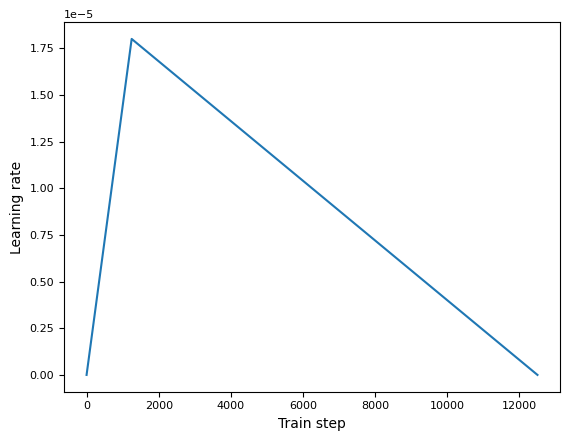

In [13]:
epochs = 20
batch_size = 32

steps_per_epoch = train_ds.cardinality().numpy()
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate = 2e-5

linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

warmup_schedule = LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x, y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')
plt.show()

Epoch 1/20


I0000 00:00:1707599730.412501   29380 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.4616 - sparse_categorical_accuracy: 0.7827 - val_loss: 0.3876 - val_sparse_categorical_accuracy: 0.8272
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.3852 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.3399 - val_sparse_categorical_accuracy: 0.8542
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.3181 - val_sparse_categorical_accuracy: 0.8664
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.3008 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.3026 - val_sparse_categorical_accuracy: 0.8746
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2754 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.2966 - val_sparse_categorical_accuracy: 0.8778
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.2517 - sparse_categorical_accuracy: 0.9008 - val_loss: 0.2956 - val_sparse_categorical_accuracy: 0.8824
Epo

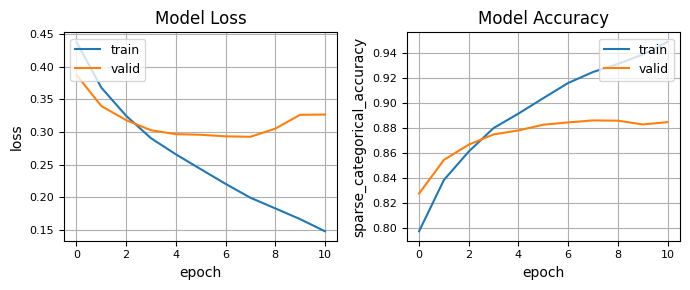

Model performance on the test set: 0.8801199793815613


In [14]:
# default dropout, lower number of training epochs
model = get_model(dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=warmup_schedule), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
e_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                   callbacks=[e_stop])
plot_history(history)
accuracy["FT-1"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-1"][1])

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - loss: 0.4121 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.3352 - val_sparse_categorical_accuracy: 0.8580
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.3283 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.3102 - val_sparse_categorical_accuracy: 0.8704
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2904 - sparse_categorical_accuracy: 0.8816 - val_loss: 0.2968 - val_sparse_categorical_accuracy: 0.8762
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2601 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.2895 - val_sparse_categorical_accuracy: 0.8778
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2323 - sparse_categorical_accuracy: 0.9104 - val_loss: 0.2866 - val_sparse_categorical_accuracy: 0.8846


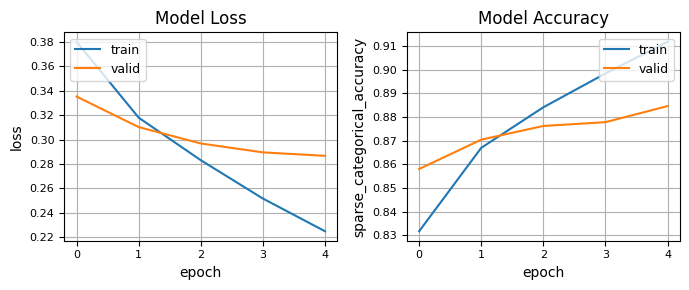

Model performance on the test set: 0.8816800117492676


In [17]:
# default dropout, lower number of training epochs
model = get_model(dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)
plot_history(history)
accuracy["FT-2"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-2"][1])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - loss: 0.4151 - sparse_categorical_accuracy: 0.8127 - val_loss: 0.3353 - val_sparse_categorical_accuracy: 0.8560
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.3295 - sparse_categorical_accuracy: 0.8574 - val_loss: 0.3108 - val_sparse_categorical_accuracy: 0.8708
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2928 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.2979 - val_sparse_categorical_accuracy: 0.8780
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2620 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.2890 - val_sparse_categorical_accuracy: 0.8806
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2344 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.2909 - val_sparse_categorical_accuracy: 0.8782
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2071 - sparse_categorical_accuracy: 0.9212 - val_loss: 0.2936 - val_sparse_categorical_accuracy:

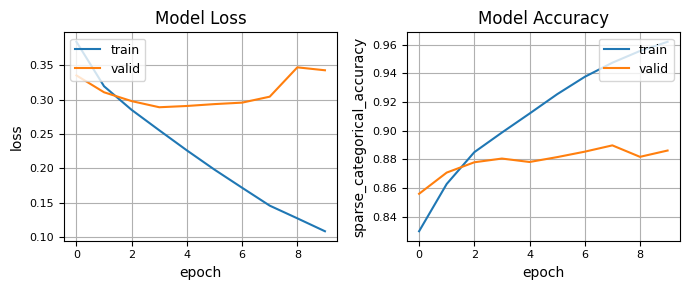

Model performance on the test set: 0.8751599788665771


In [18]:
model_2 = get_model(dropout=0.3)
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model_2.fit(train_ds, validation_data=val_ds, epochs=10)
plot_history(history)
accuracy["FT-3"] = (model_2.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model_2.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-3"][1])

Both fine-tuned models impoved baseline performance, however, model FT-3 clearly overfits the training set, whereas FT-1 and FT-2 have better performance, therefore it will be used in the inference process.

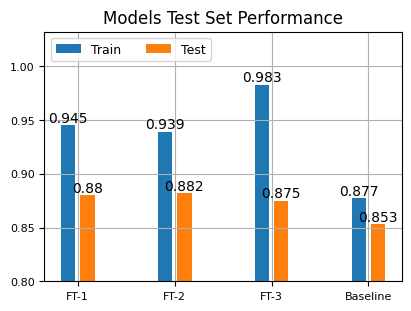

In [20]:
plot_stats(accuracy)

## Inference

Map review sentiment predictions to the sentiment range from -1 to 1: from negative (-1), neutral(0), to positive(+1).

In [13]:
# helper functions
def make_prediction(raw_review, model):
    """Args: 
    - raw_review: a single review of str type;
    - model: fine-tuned model.
    Outputs:
    - sentiment: a scalar that maps predicted review sentiments
    to fall into range [-1, 1]."""
    # convert a raw review into a tensor + batch dimension
    review = tf.expand_dims(tf.constant(raw_review), axis=0)
    # 2 neurons in the output layer, take the output of only 1 of them
    pred = model.predict(review, verbose=0)[:, 1]
    sentiment = tf.nn.tanh(pred)
    return sentiment.numpy()

def plot_bar(prediction):
    """Given a single scalar prediction plots it in a 
    colormap of a range [-1, 1]."""
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    ticks = ["negative", "neutral", "positive"]
    bounds = [-1., 0.0, 1.0]
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    ticks=bounds,
                                    orientation='horizontal')
    cb1.ax.axvline(prediction, c='green', linewidth=3)
    cb1.ax.text(prediction, 1.1, s="prediction: "+str(round(prediction[0], 2)), 
                horizontalalignment="center", fontsize=9, c="green")
    cb1.set_ticklabels(ticks)
    cb1.set_label('Sentiment Scale')

Review: This movies was wonderful, however the music was not that good.


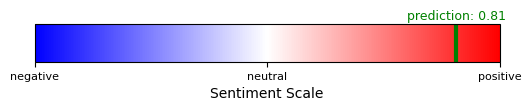

In [26]:
# test model prediction and plot result
review = "This movies was wonderful, however the music was not that good."
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: It was okay, 5 out of 10, but i wouldn't watch it again.


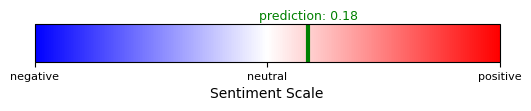

In [27]:
review = "It was okay, 5 out of 10, but i wouldn't watch it again."
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: Movie is completely awful!


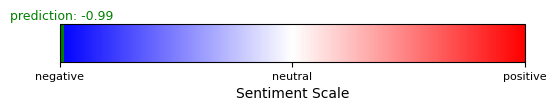

In [28]:
review = "Movie is completely awful!"
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: tf.Tensor(b'The remarkable, sometimes infuriating, often brilliant films of John Cassavetes occupy a unique position in American cinema\xc2\x85 Low-budget, partly improvised, inspired by cin\xc3\xa9ma verit\xc3\xa9 documentary, and related to underground film, they have nevertheless frequently managed to reach a wide and profoundly appreciative audience\xc2\x85 <br /><br />After drama studies, the young Cassavetes quickly made his name as an unusually unrefined, intense actor, often appearing in films about disaffected, rebellious youth such as "Crime in the Streets" and "Edge of the City." <br /><br />Setting up an actors\' workshop, he worked to transform an improvisational experiment into his feature debut\xc2\x85 The result, "Shadows," taking three years to complete and partly financed by his performances in TV\'s Johnny Staccato, was a breakthrough in American cinema\xc2\x85 About the effect of racism on an already fraught relationship between two black men and their siste

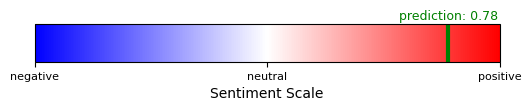

In [29]:
# test review from the test set
review_label = test_ds.unbatch().take(1)
for review, label in review_label:
    print("Review:", review)
    print("True label:", label.numpy())
    plot_bar(make_prediction(review, model))

## Error Analysis

In [20]:
def get_labels(dataset):
    # get true labels
    return tf.stack([label for _, label in dataset.unbatch()], axis=0)

def get_preds(model, dataset):
    # raw model outputs
    logits = model.predict(dataset, verbose=0)
    # class probabilities
    y_proba = tf.nn.softmax(logits)
    # predicted labels
    y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32)
    return y_pred, y_proba


y_true = get_labels(test_ds)
y_pred, y_proba = get_preds(model, test_ds)

print("Labels:", y_true)
print("Predictions:", y_pred)
print("Probabilities:", y_proba)

Labels: tf.Tensor([1 1 1 ... 1 0 0], shape=(25000,), dtype=int32)
Predictions: tf.Tensor([1 1 1 ... 1 0 0], shape=(25000,), dtype=int32)
Probabilities: tf.Tensor(
[[0.00735482 0.99264514]
 [0.05032726 0.9496727 ]
 [0.0713319  0.92866814]
 ...
 [0.07455304 0.9254469 ]
 [0.6943399  0.30566013]
 [0.8477377  0.15226232]], shape=(25000, 2), dtype=float32)


In [21]:
# utility functions to plot confusion matrix
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(3, 3)})
    ax.set_title('Confusion matrix of sentiment prediction for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

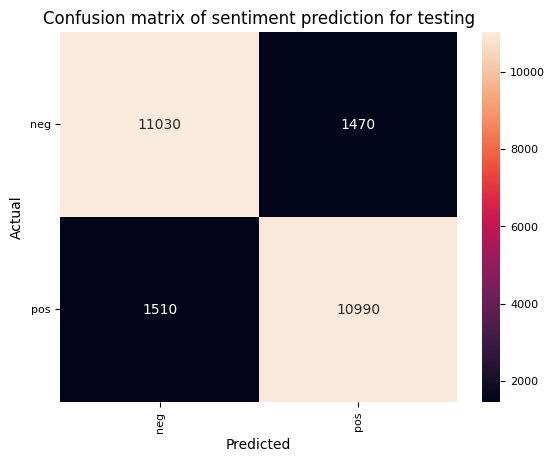

In [22]:
plot_confusion_matrix(y_true, y_pred, class_labels, "testing")

In [42]:
# get a sample of misclassified examples
def sample_misclass(size, dataset, model):
    missclass = []
    y_pred, y_proba = get_preds(model, dataset)
    
    for i, item in dataset.unbatch().enumerate():
        if item[1] != y_pred[i]:
            if len(missclass) <= size:
                missclass.append((item, y_proba[i]))
            else:
                break
    return missclass

def make_predictions(X):
    preds = model.predict(X, verbose=0)
    return preds

In [32]:
# output a few misclassified reviews
missclass = sample_misclass(size=10, dataset=test_ds, model=model)

for item, pred in missclass[0:3]:
    print("\nReview:", item[0])
    print(f"True label: {item[1].numpy()} ({class_labels[item[1].numpy()]})")
    print(f"Predicted probability of negative class: {pred.numpy()[0]}, positive class: {pred.numpy()[1]}")


Review: tf.Tensor(b"i just wanted to say i liked this movie a lot, but i also want to ask about something..does anyone know the artist/song name of the song that the young boy (cant remember his name now) plays on his cd-player when his dad and 2 men comes and takes the TV and the cd-player ??? that song is so freaking cool even though i cant understand a word what they're saying...feel free to mail me the artist/song name at hpn_x@hotmail.com thanks a lot in advance!! =) ---------------------repeating----------------------------- i just wanted to say i liked this movie a lot, but i also want to ask about something..does anyone know the artist/song name of the song that the young boy (cant remember his name now) plays on his cd-player when his dad and 2 men comes and takes the TV and the cd-player ??? that song is so freaking cool even though i cant understand a word what they're saying...feel free to mail me the artist/song name at hpn_x@hotmail.com thanks a lot in advance!! =)", sha

In [33]:
shap.initjs()

In [38]:
# set up masker and SHAP explainer
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=class_labels)

# get only review text from the misclassified examples sample
misclass_reviews = [str(text[0].numpy(), encoding='utf-8') for text, label in missclass[:1]]

print("Samples:")
for text in misclass_reviews[:1]:
    print(re.split(r"\W+", text))
    print()

Samples:
['i', 'just', 'wanted', 'to', 'say', 'i', 'liked', 'this', 'movie', 'a', 'lot', 'but', 'i', 'also', 'want', 'to', 'ask', 'about', 'something', 'does', 'anyone', 'know', 'the', 'artist', 'song', 'name', 'of', 'the', 'song', 'that', 'the', 'young', 'boy', 'cant', 'remember', 'his', 'name', 'now', 'plays', 'on', 'his', 'cd', 'player', 'when', 'his', 'dad', 'and', '2', 'men', 'comes', 'and', 'takes', 'the', 'TV', 'and', 'the', 'cd', 'player', 'that', 'song', 'is', 'so', 'freaking', 'cool', 'even', 'though', 'i', 'cant', 'understand', 'a', 'word', 'what', 'they', 're', 'saying', 'feel', 'free', 'to', 'mail', 'me', 'the', 'artist', 'song', 'name', 'at', 'hpn_x', 'hotmail', 'com', 'thanks', 'a', 'lot', 'in', 'advance', 'repeating', 'i', 'just', 'wanted', 'to', 'say', 'i', 'liked', 'this', 'movie', 'a', 'lot', 'but', 'i', 'also', 'want', 'to', 'ask', 'about', 'something', 'does', 'anyone', 'know', 'the', 'artist', 'song', 'name', 'of', 'the', 'song', 'that', 'the', 'young', 'boy', 'ca

The base value is what the model outputs when the entire input text is masked, while **f_outputclass(inputs)** is the output of the model for the full original input. The SHAP values explain in an addive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value. SHAP requires tensor outputs from the classifier, and explanations works best in additive spaces (logits or information values instead of probabilities).

In [39]:
shap_values = explainer(misclass_reviews)
shap.text_plot(shap_values)

W0000 00:00:1707591344.280007    1794 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:31, 91.57s/it]                                                


In [40]:
def clean_text(text):
    return tf.strings.regex_replace(text, "<[^>]+>", " ")

train_ds = train_ds.map(lambda x, y: (clean_text(x), y))
val_ds = val_ds.map(lambda x, y: (clean_text(x), y))
test_ds = test_ds.map(lambda x, y: (clean_text(x), y))

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - loss: 0.4102 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.3326 - val_sparse_categorical_accuracy: 0.8570
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.3258 - sparse_categorical_accuracy: 0.8633 - val_loss: 0.3072 - val_sparse_categorical_accuracy: 0.8694
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2874 - sparse_categorical_accuracy: 0.8824 - val_loss: 0.2931 - val_sparse_categorical_accuracy: 0.8790
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2579 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.2859 - val_sparse_categorical_accuracy: 0.8850
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2306 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.2807 - val_sparse_categorical_accuracy: 0.8866


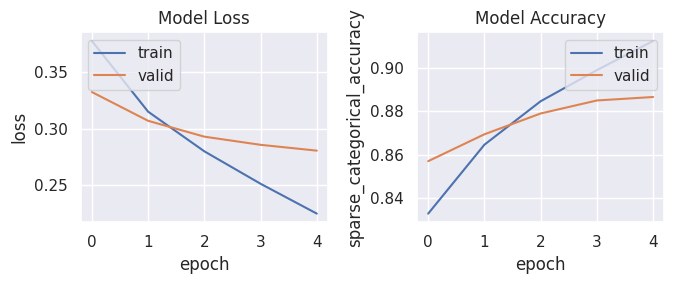

Model performance on the test set: 0.881600022315979


In [41]:
# default dropout, lower number of training epochs, cleaned inputs
model = get_model(dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)
plot_history(history)
accuracy["FT-3"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-3"][1])

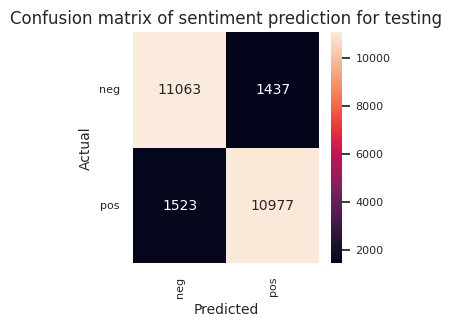

In [47]:
y_true = get_labels(test_ds)
y_pred, y_proba = get_preds(model, test_ds)
plot_confusion_matrix(y_true, y_pred, class_labels, "testing")

In [45]:
# output a few misclassified reviews
missclass = sample_misclass(size=10, dataset=test_ds, model=model)

for item, pred in missclass[0:3]:
    print("\nReview:", item[0])
    print(f"True label: {item[1].numpy()} ({class_labels[item[1].numpy()]})")
    print(f"Predicted probability of negative class: {pred.numpy()[0]}, positive class: {pred.numpy()[1]}")


Review: tf.Tensor(b"This movie was very disappointing in that several elements of the book were wrongly done. The main story is the same but there are several flaws that hurt the movie.  1) Boobie Miles gets injured in the beginning of the story in a preseason game at Texas Tech. This means he won't get anything done during the season at all and Chris Comer comes up sooner on the team.  2) The game against Marshall was lost at Marshall. The team depicted as Marshall was actually Midland High one of Permian's main rivals and here is the proof- Marshall High is the Mavericks colored Scarlet and Silver, Midland High is the Bulldogs colored Purple and Gold. Look at the jerseys and you will see who it is. Also the real Marshall High's football roster is overwhelmingly Black, the team shown was racially mixed like Midland High.   3) Permian only loses to Midland Lee by one point in district play. Midland Lee loses to Midland High and Midland High loses to Permian. These are the teams that s

In [48]:
# get only review text from the misclassified examples sample
misclass_reviews = [str(text[0].numpy(), encoding='utf-8') for text, label in missclass[:1]]

explainer = shap.Explainer(make_predictions, masker=masker, output_names=class_labels)
shap_values = explainer(misclass_reviews)
shap.text_plot(shap_values)

W0000 00:00:1707592048.401693    1793 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:27, 87.76s/it]                                                


In [49]:
# shap.text_plot(shap_values[0][:, 0]) 